In [1]:
from statsforecast import StatsForecast
from statsforecast.models import (AutoARIMA, AutoETS, AutoTheta, AutoCES)
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import yfinance as yf
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsforecast/core.py:27: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
# Descargar datos
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'NVDA', 'META', 'IBM', 'BTC-USD']
Y_df = yf.download(tickers, start='2000-01-01', interval='1wk')['Adj Close']

# Resetear el índice y transformar el DataFrame
Y_df = Y_df.reset_index().melt(id_vars='Date', var_name='unique_id', value_name='y')
Y_df = Y_df.rename(columns={'Date': 'ds'})
Y_df = Y_df[['unique_id', 'ds', 'y']]
Y_df = Y_df.dropna(subset=['y']).reset_index(drop=True)

[*********************100%%**********************]  8 of 8 completed


In [3]:
# Split data into training and testing sets
Y_train_df = Y_df[Y_df.ds <= '2023-01-01'] # Train set
Y_test_df = Y_df[Y_df.ds > '2023-01-01']   # Test set

In [4]:
season_length = 52 # Define season length as 12 months for monthly data

# Define a list of models for forecasting
models = [
    AutoARIMA(season_length=season_length), # ARIMA model with automatic order selection and seasonal component
    AutoETS(season_length=season_length), # ETS model with automatic error, trend, and seasonal component
    AutoTheta(season_length=season_length), # Theta model with automatic seasonality detection
    AutoCES(season_length=season_length), # CES model with automatic seasonality detection
    
]

# Instantiate StatsForecast class with models, data frequency ('M' for monthly),
# and parallel computation on all CPU cores (n_jobs=-1)
sf = StatsForecast(
    models=models, # models for forecasting
    freq='W',  # frequency of the data
    n_jobs=-1  # number of jobs to run in parallel, -1 means using all processors
)

sf.fit(df=Y_df)

StatsForecast(models=[AutoARIMA,AutoETS,AutoTheta,CES])

In [5]:
# Generate forecasts for the specified horizon using the sf object
horizon = 7
Y_hat_df = sf.forecast(df=Y_train_df, h=horizon) # forecast data
Y_hat_df.head(5) 

,ds,AutoARIMA,AutoETS,AutoTheta,CES
unique_id,,,,,
AAPL,2023-01-01,128.872131,128.575684,128.583878,128.755875
AAPL,2023-01-08,128.663208,128.590469,128.271881,128.843292
AAPL,2023-01-15,129.630478,128.605255,129.310730,128.850113
AAPL,2023-01-22,129.539001,128.620056,130.799316,129.587051
AAPL,2023-01-29,129.755493,128.634842,131.618515,129.755753


In [6]:
Y_hat_df = Y_hat_df.reset_index()

def symmetric_mean_absolute_percentage_error(y_true, y_pred):
    return 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

def evaluate_forecast(y_true, y_pred):
    results = pd.DataFrame({
        'mae': [mean_absolute_error(y_true, y_pred)],
        'mse': [mean_squared_error(y_true, y_pred)],
        'mape': [mean_absolute_percentage_error(y_true, y_pred)],
        'rmse': [np.sqrt(mean_squared_error(y_true, y_pred))],
        'smape:': [symmetric_mean_absolute_percentage_error(y_true, y_pred)],
    })
    return results

# Evaluar múltiples modelos para múltiples tickers
evaluation_results_all_models = {}
models_to_evaluate = ['AutoARIMA', 'AutoETS', 'AutoTheta', 'CES']

for ticker in tickers:
    evaluation_results_all_models[ticker] = {}
    Y_test_true = Y_test_df[Y_test_df['unique_id'] == ticker]['y'].values[:horizon]
    for model in models_to_evaluate:
        Y_test_pred = Y_hat_df.loc[Y_hat_df['unique_id'] == ticker, model].values[:horizon]
        evaluation_results_all_models[ticker][model] = evaluate_forecast(Y_test_true, Y_test_pred)

# Imprimir resultados de evaluación para todos los modelos y tickers
for ticker, models_results in evaluation_results_all_models.items():
    print(f"Results for {ticker}:")
    for model, results in models_results.items():
        print(f"Model: {model}")
        print(results)
        print()

Results for AAPL:
Model: AutoARIMA
         mae         mse      mape       rmse     smape:
0  15.852864  295.172559  0.107316  17.180587  11.441082

Model: AutoETS
         mae         mse      mape       rmse    smape:
0  16.440162  317.229197  0.111294  17.810929  11.89397

Model: AutoTheta
         mae         mse      mape       rmse     smape:
0  14.986513  259.118708  0.101593  16.097165  10.780455

Model: CES
         mae         mse      mape       rmse     smape:
0  16.007577  299.744409  0.108392  17.313128  11.560768

Results for MSFT:
Model: AutoARIMA
         mae         mse      mape       rmse    smape:
0  28.817435  938.424719  0.114958  30.633719  12.28403

Model: AutoETS
         mae         mse      mape      rmse     smape:
0  24.739182  682.248106  0.098759  26.11988  10.443115

Model: AutoTheta
         mae         mse      mape       rmse     smape:
0  27.924465  861.021143  0.111541  29.343162  11.876778

Model: CES
         mae         mse      mape       rmse

In [7]:
cv_df = sf.cross_validation(df=Y_train_df, h=7, n_windows=3, step_size=7, level=[99])
cv_df.head(5)

,ds,cutoff,y,AutoARIMA,AutoARIMA-lo-99,AutoARIMA-hi-99,AutoETS,AutoETS-lo-99,AutoETS-hi-99,AutoTheta,AutoTheta-lo-99,AutoTheta-hi-99,CES,CES-lo-99,CES-hi-99
unique_id,,,,,,,,,,,,,,,
AAPL,2022-08-13,2022-08-06,169.836761,171.846146,167.024017,176.668274,170.803635,147.836441,193.770813,170.276749,165.923691,174.718384,170.115509,163.449020,176.924866
AAPL,2022-08-20,2022-08-06,162.014297,172.774994,165.998230,179.551758,171.196838,138.594269,203.799423,169.840790,163.489563,176.668106,170.975784,164.227798,177.881866
AAPL,2022-08-27,2022-08-06,154.280960,174.104553,165.737106,182.472000,171.590057,131.509018,211.671082,163.775589,156.481384,171.186630,171.430023,164.678696,178.613937
AAPL,2022-09-03,2022-08-06,155.825607,174.712982,164.672714,184.753250,171.983261,125.526306,218.440216,163.785675,154.627884,173.435837,171.534286,164.535172,178.366104
AAPL,2022-09-10,2022-08-06,149.221085,175.279572,163.802261,186.756866,172.376480,120.239311,224.513641,160.729828,150.790741,169.377197,171.189789,164.454224,178.243866


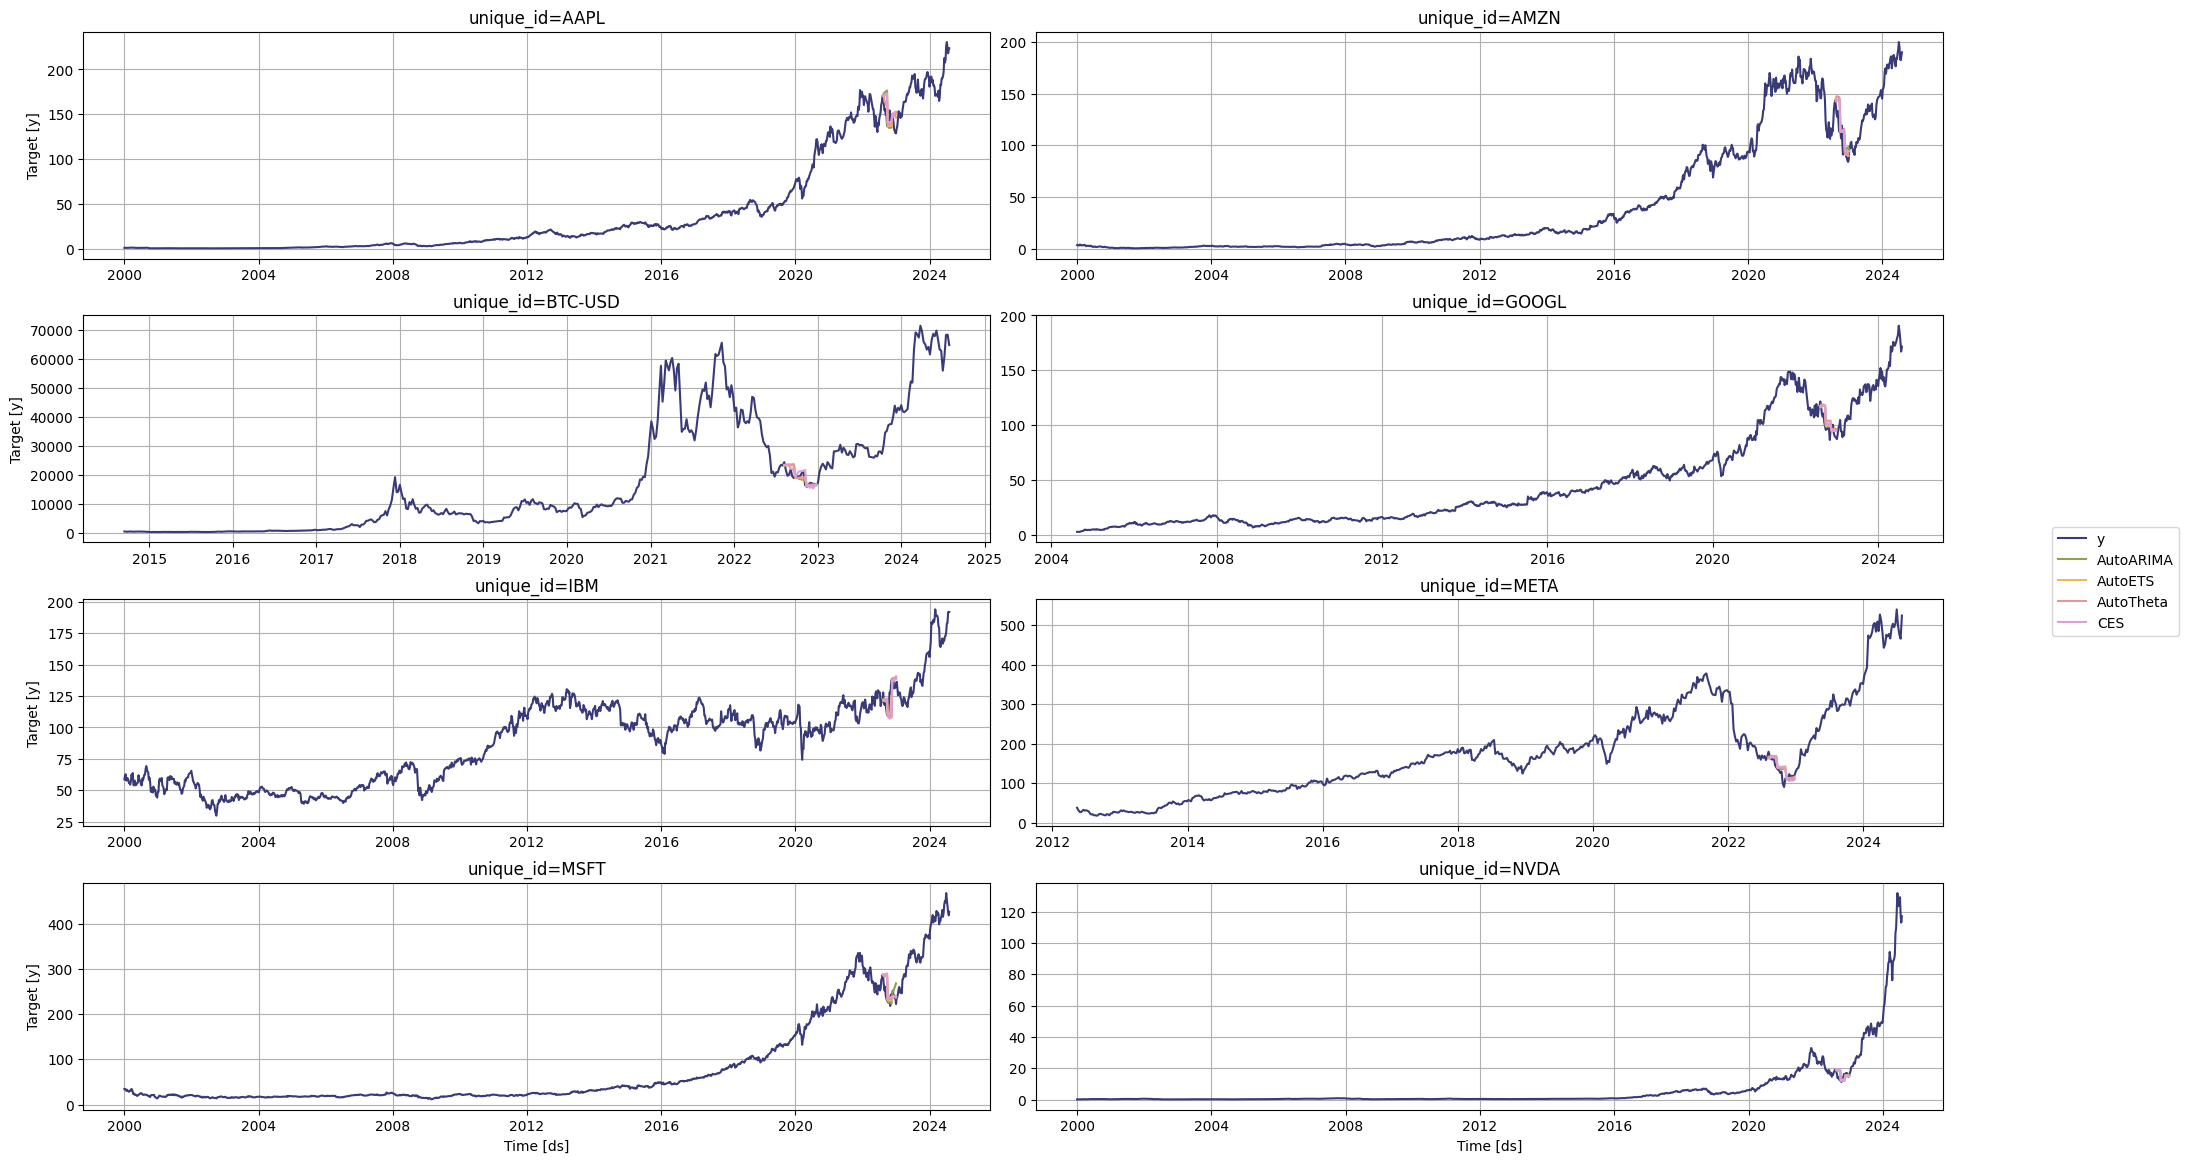

In [8]:
StatsForecast.plot(Y_df, cv_df.drop(['cutoff', 'y'], axis=1))